In [12]:
import scipy.io as sio    # import scipy.io for .mat file I/O
import scipy
from scipy import stats  
import numpy as np                         # import numpy
import matplotlib.pyplot as plt            # import matplotlib.pyplot for figure plotting
import torch
import dc_stat_think as dcst
import function_wmmse_powercontrol as wmmse_pc
import subnetwork_generator
import tikzplotlib
import time
import math

In [3]:
class init_parameters:
    def __init__(self):
        self.num_of_subnetworks = 20
        self.deploy_length = 20     # m
        self.subnet_radius = 2      # m
        self.minD = 0.5               #device to controller m
        self.minDistance = self.subnet_radius    #controller to controller distance m
        self.sigmaS = 7             #shadowing standard deviation
        self.transmit_power_dBm = 0  # P_max for OLPC dBm 
        self.rng_value = np.random.RandomState(1)
        self.transmit_power = 1      #normalized transmit power mW 
        self.bandwidth = 20e6         #Hz
        self.P0 = -50                #dBm
        self.frequency = 6e9          #dBm
        self.lambdA = 3e8/6e9        
        self.plExponent = 2.7        #path loss exponent

        
config = init_parameters()
testing_snapshots = 50000

test_powers, PC, dist = subnetwork_generator.generate_samples(config, testing_snapshots)
bandwidth = config.bandwidth
Noise_power = np.power(10,((-174+10+10*np.log10(bandwidth))/10))


In [4]:
def mycapacity(weights, data, num_subnetworks):

    weights = weights.reshape([-1,num_subnetworks,1,1])
    
    power_mat = data.reshape([-1,num_subnetworks,num_subnetworks,1])

    weighted_powers = torch.mul(weights,power_mat) #received powers
    
    eye = torch.eye(num_subnetworks)
    
    desired_rcv_power = torch.sum(torch.mul(weighted_powers.squeeze(-1),eye), dim=1)
   
    Interference_power = torch.sum(torch.mul(weighted_powers.squeeze(-1),1-eye), dim=1)

    signal_interference_ratio = torch.divide(desired_rcv_power,Interference_power+Noise_power)
    
    capacity = torch.log2(1+signal_interference_ratio)
    
    return capacity, weighted_powers   

In [5]:
def generate_cdf(values, bins_):
    data = np.array(values)
    count, bins_count = np.histogram(data, bins=bins_)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count[1:], cdf

In [6]:
def WMMSE_powers_sum_rate(K=config.num_of_subnetworks, num_H=testing_snapshots, Pmax=1, Pmin=0):
    Pini = Pmax*np.ones(K)
    var_noise = Noise_power
    X=np.zeros((K**2,num_H))
    Y=np.zeros((K,num_H))
    iter_ = np.zeros(num_H)
    total_time = 0.0
    for loop in range(num_H):
        H=test_powers[loop,:,:]
        X[:,loop] = np.reshape(H, (K**2,), order="F")
        H=np.reshape(X[:,loop], (K,K), order="F")
        mid_time = time.time()
        Y[:,loop], iter_[loop] = wmmse_pc.WMMSE_sum_rate(Pini, H, Pmax, var_noise)
        total_time = total_time + time.time() - mid_time
    # print("wmmse time: %0.2f s" % total_time)
    return X, Y, total_time, iter_
    

In [7]:
X_sr,Y_sr,t_sr, iter_ = WMMSE_powers_sum_rate()

In [8]:
WMMSE_capacities_sr, powers_sr = mycapacity(torch.tensor(np.transpose(Y_sr)), torch.tensor(test_powers), config.num_of_subnetworks)
weights_ones = torch.ones_like(torch.tensor(np.transpose(Y_sr)))
capacities_ones, Uniform_pow = mycapacity(weights_ones, torch.tensor(test_powers),config.num_of_subnetworks)

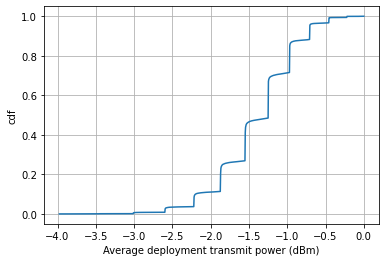

In [20]:
#WMMSE Sum rate powers
x,y = generate_cdf(10*np.log10(np.sum(Y_sr,0)/20), 1000)
#x, y = dcst.ecdf(np.sum(10*np.log10(Y_sr),0)/20)
plt.plot(x,y)
plt.ylabel('cdf')
plt.xlabel('Average deployment transmit power (dBm)')
tikzplotlib.save("tikz files/cs5WMMSE_sr_pow__.tex")
plt.grid()

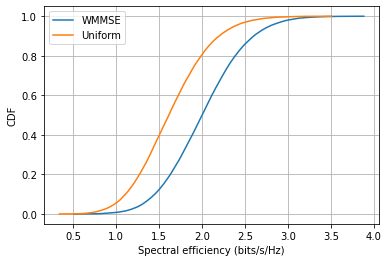

In [23]:
## WMMSE Sum rate sum capacities
x,y = generate_cdf(torch.sum(WMMSE_capacities_sr,1)/20, 1000)
plt.plot(x,y,label="WMMSE")
x,y = generate_cdf(torch.sum(capacities_ones,1)/20, 1000)
plt.plot(x,y,label="Uniform")
plt.legend()
plt.ylabel('CDF')
plt.xlabel('Spectral efficiency (bits/s/Hz)')
tikzplotlib.save("tikz files/csWMMSE_sr_sumCap.tex")
plt.grid()